In [163]:
# !pip install scipy
# !pip install tqdm
# !pip install matplotlib
# !pip install numpy
# !pip install line-profiler
from tqdm import tqdm
import cProfile
import pstats
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix

5920.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [169]:
# %load_ext line_profiler
# %lprun -f mm_algorithm mm_algorithm(x0, theta, max_iter)

## I. X-ray tomography

In [161]:
N = 8100
M = 16200
lambda_ = 0.13
delta = 0.02

G = scipy.io.loadmat('data/G.mat')['G']
G = csr_matrix(G)
H = scipy.io.loadmat('data/H.mat')['H']
# H = csr_matrix(H)

x_bar = scipy.io.loadmat('data/x.mat')['x'].reshape(N)
w = np.random.randn(M)
y = H @ x_bar + w

x_bar_sinogram = x_bar.reshape((90, 90), order='F')
y_sinogram = y.reshape((90, 180), order='F')

In [173]:
G

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 32400 stored elements and shape (16200, 8100)>

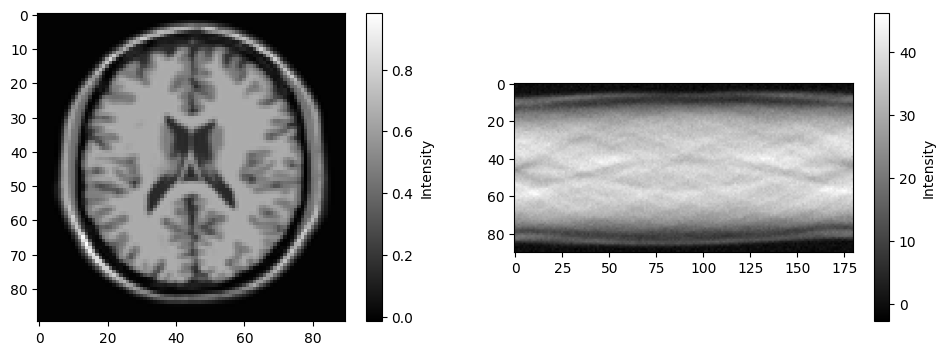

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# axs[0].imshow(x_bar_sinogram, cmap='gray')
fig.colorbar(axs[0].imshow(x_bar_sinogram, cmap='gray'), ax=axs[0], label='Intensity')

# axs[1].imshow(y_sinogram, cmap='gray')
fig.colorbar(axs[1].imshow(y_sinogram, cmap='gray'), ax=axs[1], label='Intensity')

## II. Optimization problem

In [117]:
def phi(x: np.ndarray) -> float:
    def phi_scalar(x: float) -> float:
        return np.sqrt(1 + x**2/delta**2)
    phi_vect = np.vectorize(phi_scalar)
    return phi_vect(x)

def phi_prime(x: np.ndarray) -> np.ndarray:
    def phi_prime_scalar(x: float) -> float:
        return x/((delta**2)*phi(x))
    phi_prime_vect = np.vectorize(phi_prime_scalar)
    return phi_prime_vect(x)

def phi_second(x: np.ndarray) -> np.ndarray:
    def phi_second_scalar(x: float) -> float:
        return (phi(x) - x * phi_prime(x))/(delta**2 * phi(x)**2)
    phi_second_vect = np.vectorize(phi_second_scalar)
    return phi_second_vect(x)

def r(x: np.ndarray, G:np.ndarray) -> float:
    return np.sum(phi(G @ x))

def grad_r(x: np.ndarray, G:np.ndarray) -> np.ndarray:
    return G.T @ phi_prime(G @ x)

def hessian_r(x: np.ndarray, G:np.ndarray) -> np.ndarray:
    return G.T @ np.diag(phi_second(G @ x).flatten()) @ G        

def f(x: np.ndarray, H: np.ndarray, G:np.ndarray, y:np.array) -> float:
    return 0.5 * np.linalg.norm(H @ x - y)**2 + lambda_ * r(x, G)

def grad_f(x: np.ndarray, H: np.ndarray, G: np.ndarray, y:np.array) -> np.ndarray:
    return H.T @ (H @ x - y) + lambda_ * grad_r(x, G)

def hessian_f(x: np.ndarray, H: np.ndarray,G:np.ndarray, y:np.array) -> np.ndarray:
    return H.T @ H + lambda_ * hessian_r(x, G)

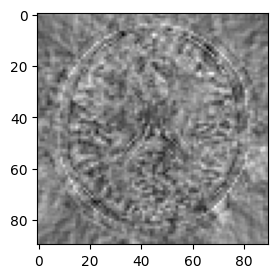

In [118]:
grad_test = grad_f(x_bar, H, G, y)
plt.figure(figsize=(3,3))
plt.imshow(grad_test.reshape((90, 90), order='F'), cmap='gray')

### Q3

## Optimization algorithms

In [119]:
x0 = np.zeros(N)

L = scipy.sparse.linalg.svds(H, k=1, return_singular_vectors=False)[0]**2 + (lambda_/delta**2) * scipy.sparse.linalg.svds(G, k=1, return_singular_vectors=False)[0]**2


### I. Gradient Descent

Iter: 10, Grad Norm: 7837.576069436142
Iter: 20, Grad Norm: 3668.3202238215827
Iter: 30, Grad Norm: 2415.3588026595207
Iter: 40, Grad Norm: 1776.5920038866982
Iter: 50, Grad Norm: 1367.953829579482
Iter: 60, Grad Norm: 1083.3308692802327
Iter: 70, Grad Norm: 876.2741650628941
Iter: 80, Grad Norm: 721.4952994328154
Iter: 90, Grad Norm: 602.9779435262315
Iter: 100, Grad Norm: 510.4621126678841
Iter: 110, Grad Norm: 437.33308485285914
Iter: 120, Grad Norm: 378.6969150786009
Iter: 130, Grad Norm: 331.00929456873075
Iter: 140, Grad Norm: 291.84520875527676
Iter: 150, Grad Norm: 259.3088066256534
Iter: 160, Grad Norm: 231.83626952194692
Iter: 170, Grad Norm: 208.2549683900324
Iter: 180, Grad Norm: 188.00459561788898
Iter: 190, Grad Norm: 170.74344003860065
Iter: 200, Grad Norm: 155.95871981480786
Iter: 210, Grad Norm: 143.18658558764886
Iter: 220, Grad Norm: 132.0070477468627
Iter: 230, Grad Norm: 122.09123003560414
Iter: 240, Grad Norm: 113.24139979396098
Iter: 250, Grad Norm: 105.339486352

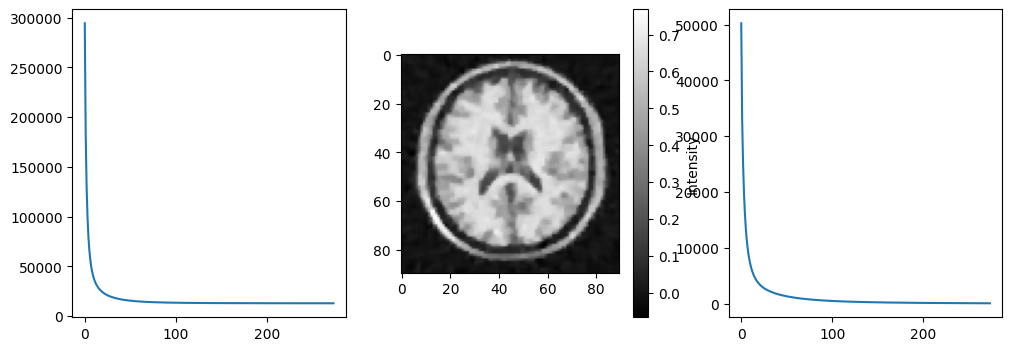

In [171]:
def grad_desc(x0: np.ndarray, eta: float, lambda_: float, delta: float, max_iter: int):
    x_gd = x0
    loss_history = []
    grad_norm_history = []
    x_history = []
    n_iter = 0
    # for i in tqdm(range(max_iter)):
    while np.linalg.norm(grad_f(x_gd, H, G, y)) > 1 * np.sqrt(N):
        x_gd = x_gd - eta*grad_f(x_gd, H, G, y) 
        loss_history.append(f(x_gd, H, G, y))
        x_history.append(x_gd)
        grad_norm_history.append(np.linalg.norm(grad_f(x_gd, H, G, y)))
        n_iter += 1
        if n_iter%10 == 0:
            print(f'Iter: {n_iter}, Grad Norm: {grad_norm_history[-1]}')
    return x_gd, loss_history, x_history, grad_norm_history

eta = 1/L
max_iter = 20
x_gd, loss_history, x_history, grad_norm_history = grad_desc(x0, eta, lambda_, delta, max_iter)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_history)
fig.colorbar(axs[1].imshow(x_gd.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')
axs[2].plot(grad_norm_history)

### MM quadratic algorithm

 21%|██        | 21/100 [00:02<00:10,  7.48it/s]

Iter: 20, grad norm: 45375.119500845016


 41%|████      | 41/100 [00:04<00:07,  7.64it/s]

Iter: 40, grad norm: 22730.836738560636


 61%|██████    | 61/100 [00:07<00:05,  7.58it/s]

Iter: 60, grad norm: 15140.267134783686


 81%|████████  | 81/100 [00:09<00:02,  7.67it/s]

Iter: 80, grad norm: 11040.426931782747


100%|██████████| 100/100 [00:11<00:00,  8.60it/s]

Iter: 100, grad norm: 8532.997788156512


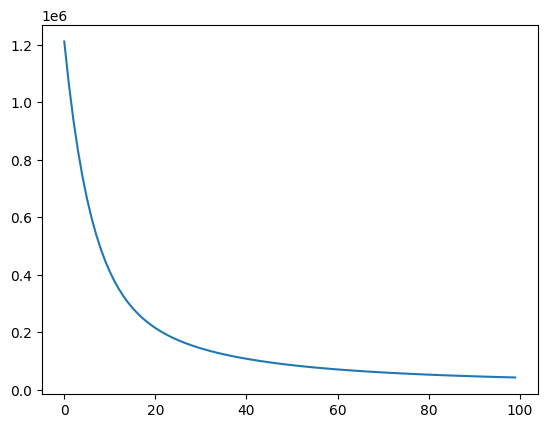

In [180]:
from scipy.sparse import diags
from scipy.sparse.linalg import LinearOperator, cg, eigsh, bicg


def A(x: np.ndarray) -> np.ndarray:
    # hessian = hessian_f(x, H, G, y)
    # sparse_hessian = csr_matrix(hessian)
    # d, p = eigsh(sparse_hessian, k=1)

    d = np.full(N, L + 1)      # check that 1 is a good margin
    curvature = diags(d).tocsc()

    def matvec(v):
        return curvature @ v
    
    def rmatvec(v):
        return curvature.T @ v
    
    A = LinearOperator((N, N), matvec=matvec, rmatvec=rmatvec)

    return A


def mm_algorithm(x0: np.ndarray, theta: float, max_iter: int): #theta cst over the iterations for now
    x_mm = x0
    loss_history = []
    x_history = []
    n_iter = 0
    for i in tqdm(range(max_iter)):
    # while np.linalg.norm(grad_f(x_mm, H, G, y)) > 1 * np.sqrt(N):
        grad_mm = grad_f(x_mm, H, G, y)
        A_mm = A(x_mm)
        v, info = bicg(A_mm, grad_mm)
        if info != 0:
            raise ValueError ("CG did not converge")
        
        x_mm = x_mm - theta*v 
        x_history.append(x_mm)
        loss_history.append(f(x_mm, H, G, y))
        n_iter += 1
        if n_iter%20 == 0:
            print(f'Iter: {n_iter}, grad norm: {np.linalg.norm(grad_f(x_mm, H, G, y))}')
    return x_mm, loss_history, x_history

theta = 0.1
max_iter = 100
x_mm, loss_history_mm, x_history_mm = mm_algorithm(x0, theta, max_iter)
plt.plot(loss_history_mm)
# xtest = np.random.randn(N)
# A(xtest)

In [151]:
cProfile.run('mm_algorithm(x0, theta, max_iter)', 'profile_results')
p = pstats.Stats('profile_results')
p.strip_dirs().sort_stats('cumulative').print_stats(20)

100%|██████████| 1/1 [00:06<00:00,  6.87s/it]

Iter: 1, grad norm: 164131.1229177285
Sat Jan 25 23:11:46 2025    profile_results

         2913350 function calls (2556263 primitive calls) in 6.876 seconds

   Ordered by: cumulative time
   List reduced from 497 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  137/134    0.004    0.000    8.616    0.064 threading.py:323(wait)
    72/69    0.010    0.000    7.553    0.109 threading.py:637(wait)
        1    0.000    0.000    6.872    6.872 {built-in method builtins.exec}
        1    0.000    0.000    6.863    6.863 <string>:1(<module>)
       37    0.002    0.000    3.669    0.099 _base.py:727(__matmul__)
        1    0.009    0.009    2.998    2.998 1355471003.py:24(mm_algorithm)
        1    0.016    0.016    2.167    2.167 3322172153.py:25(hessian_r)
    98/64    0.002    0.000    2.054    0.032 queue.py:154(get)
        1    0.012    0.012    1.693    1.693 1355471003.py:5(A)
        1    0.000    0.000    1.399    1.399 ar

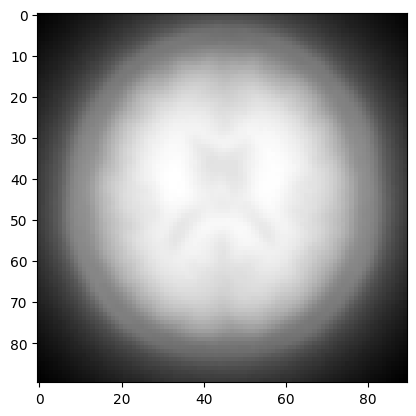

In [122]:
# plt.plot(loss_history_mm)
plt.imshow(x_mm.reshape((90,90), order='F'), cmap='gray')

In [123]:
def mg_algo(x0: np.ndarray, max_iter: int) -> np.ndarray:
    x3mg = x0
    loss_history = []
    x_history = []
    D = np.zeros((N, 2))
    for i in tqdm(range(max_iter)):
        D[:,0] = -grad_f(x3mg, H, G, y)
        A3mg = A(x3mg)
        u = -np.linalg.pinv(D.T @ A3mg @ D) @ (D.T @ grad_f(x3mg, H, G, y))
        x3mg += D @ u
        D[:,1] = D @ u
        loss_history.append(f(x3mg, H, G, y))
        x_history.append(x3mg)
    return x3mg, loss_history, x_history

max_iter = 1
x_3mg, loss_history_3mg, x_history_3mg = mg_algo(x0, max_iter)

100%|██████████| 1/1 [00:06<00:00,  6.17s/it]


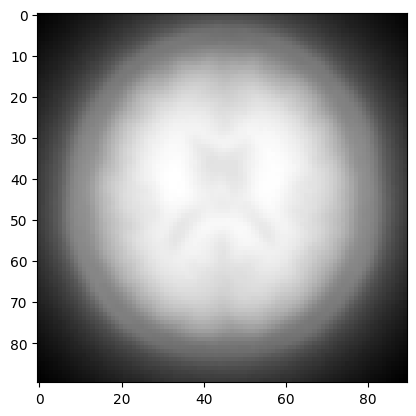

In [124]:
# plt.plot(loss_history_3mg)
plt.imshow(x_3mg.reshape((90,90), order='F'), cmap='gray')

### IV. Block coordinate MM quadratic algorithm

100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


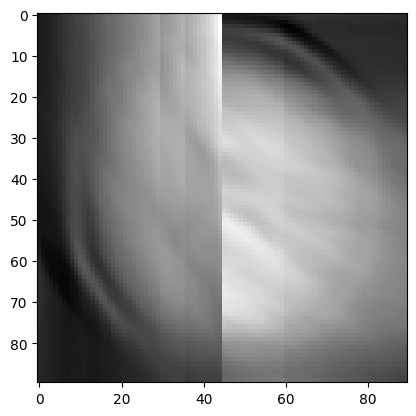

In [132]:
def Aj(x: np.ndarray, j:int, J:int) -> np.ndarray:
    Nj = N//J
    indices = range(Nj*j, Nj*(j+ 1))
    xj = x[indices]
    Hj = H[indices, :][:,indices]
    Gj = G[indices, :][:,indices]
    yj = y[indices]
    hessian = hessian_f(xj, Hj, Gj, yj)
    sparse_hessian = csr_matrix(hessian)
    d, p = eigsh(sparse_hessian, k=1)

    d = np.full(Nj, d[0] + 1)      # check that 1 is a good margin
    curvature = diags(d).tocsc()  # Might work?

    def matvec(v):
        return curvature @ v
    
    def rmatvec(v):
        return curvature.T @ v
    
    Aj = LinearOperator((Nj, Nj), matvec=matvec, rmatvec=rmatvec)

    return Aj


def block_mm(x0: np.array, theta: float, max_iter: int, J:int) -> np.array:
    x = x0
    Nj = N//J
    x_history = []
    loss_history = []
    for i in tqdm(range(max_iter)):
        j = i%J
        indices = range(Nj*j, Nj*(j+1))
        Hj = H[indices, :][:, indices]
        Gj = G[indices, :][:, indices]
        yj = y[indices]
        xj = x[indices]
        Aj_mm = Aj(x, j, J)
        gradj = grad_f(xj, Hj, Gj, yj)
        v, info = cg(Aj_mm, gradj)
        if info != 0:
            raise ValueError("Conjugate gradient solver did not converge")
        x[indices] = xj - theta*v       
        x_history.append(x)
        loss_history.append(f(x, H, G, y))
    return x, loss_history, x_history

theta = 0.1
max_iter = 2
J = 1
x_block_mm, loss_history_block_mm, x_history_block_mm = block_mm(x0, theta, max_iter, J)
plt.imshow(x_block_mm.reshape((90,90), order='F'), cmap='gray')

In [126]:
plt.plot(loss_history_block_mm

SyntaxError: incomplete input (221868045.py, line 1)

### V. Parallel MM quadratic algorithm